In [1]:
#https://github.com/jerett/Keras-CIFAR10/blob/master/classifiers/ResNet.py

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.keras.backend.clear_session()

### dataset information

In [6]:
from datetime import datetime
dataset = 'cifar10'
dims = (32,32,3)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = str(dataset) + '_' + str(umap_prop) + '_'  +  str(PROJECTION_DIMS)+ '_'  + str(labels_per_class) + '____' + datestring
print(datestring)

cifar10_0.0_1024_full____2020_07_31_13_02_05_538740


### Load packages

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import time


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [8]:
from tfumap.load_datasets import load_CIFAR10, mask_labels

In [9]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [10]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### train

In [11]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [27]:
def plot_history(history):
    """
    plot train epoch history and acc
    :param history: train history object returned by CIFAR10Solver.train()
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('acc value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [14]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

In [15]:
X_labeled.shape

(40000, 32, 32, 3)

In [16]:
block_layers_num = 3
weight_decay = 1e-4
name = 'resnet20'

In [17]:
block_layers_num

In [18]:
model.summary()

Model: "resnet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [19]:
from tensorflow.keras import losses

In [20]:
opt = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=opt,
                 loss=losses.sparse_categorical_crossentropy,
                 metrics=['accuracy'])

In [22]:
# Train the model
start = time.time()
history = model.fit(X_labeled, Y_labeled, 
                       batch_size=128,
                       epochs= 50,
                       validation_data = (X_valid, Y_valid))

end = time.time()

Epoch 1/50
313/313 [==============================] - 5s 15ms/step - loss: 0.4504 - accuracy: 0.8758 - val_loss: 1.5350 - val_accuracy: 0.6317
Epoch 2/50
313/313 [==============================] - 5s 15ms/step - loss: 0.4129 - accuracy: 0.8903 - val_loss: 1.1609 - val_accuracy: 0.6932
Epoch 3/50
313/313 [==============================] - 5s 15ms/step - loss: 0.3798 - accuracy: 0.9044 - val_loss: 1.0023 - val_accuracy: 0.7364
Epoch 4/50
313/313 [==============================] - 5s 15ms/step - loss: 0.3571 - accuracy: 0.9136 - val_loss: 1.5237 - val_accuracy: 0.6669
Epoch 5/50
313/313 [==============================] - 5s 15ms/step - loss: 0.3318 - accuracy: 0.9232 - val_loss: 1.2433 - val_accuracy: 0.7096
Epoch 6/50
313/313 [==============================] - 5s 15ms/step - loss: 0.3098 - accuracy: 0.9322 - val_loss: 1.4881 - val_accuracy: 0.6890
Epoch 7/50
313/313 [==============================] - 5s 15ms/step - loss: 0.2870 - accuracy: 0.9410 - val_loss: 1.5266 - val_accuracy: 0.6931

In [23]:
loss, acc = model.evaluate(X_test, Y_test)
print('test data loss:%.2f acc:%.4f' % (loss, acc))

313/313 [==============================] - 1s 4ms/step - loss: 1.5314 - accuracy: 0.7372
test data loss:1.53 acc:0.7372


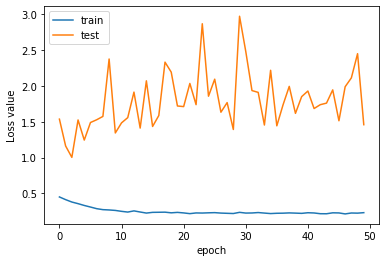

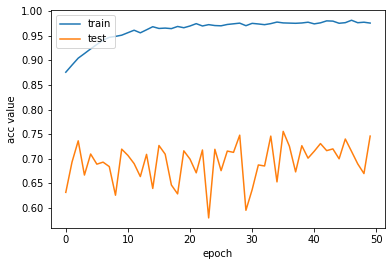

In [28]:
plot_history(history)

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    # rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=4,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)

In [30]:
batch_size = 128
train_gen = datagen.flow(X_labeled, Y_labeled, batch_size=batch_size)

In [31]:
history = model.fit(
    train_gen,  epochs=50, validation_data=(X_valid, Y_valid),
    use_multiprocessing=True,
    workers=tf.data.experimental.AUTOTUNE, 
)

Epoch 1/50
313/313 [==============================] - 19s 60ms/step - loss: 0.7817 - accuracy: 0.8030 - val_loss: 0.8099 - val_accuracy: 0.7797
Epoch 2/50
313/313 [==============================] - 19s 60ms/step - loss: 0.6581 - accuracy: 0.8299 - val_loss: 0.9173 - val_accuracy: 0.7559
Epoch 3/50
313/313 [==============================] - 19s 60ms/step - loss: 0.6179 - accuracy: 0.8425 - val_loss: 0.7033 - val_accuracy: 0.8225
Epoch 4/50
313/313 [==============================] - 19s 60ms/step - loss: 0.5998 - accuracy: 0.8489 - val_loss: 0.7115 - val_accuracy: 0.8163
Epoch 5/50
313/313 [==============================] - 19s 59ms/step - loss: 0.5888 - accuracy: 0.8515 - val_loss: 0.7785 - val_accuracy: 0.8018
Epoch 6/50
313/313 [==============================] - 19s 60ms/step - loss: 0.5671 - accuracy: 0.8574 - val_loss: 0.7209 - val_accuracy: 0.8151
Epoch 7/50
313/313 [==============================] - 19s 60ms/step - loss: 0.5538 - accuracy: 0.8632 - val_loss: 0.7128 - val_accuracy:

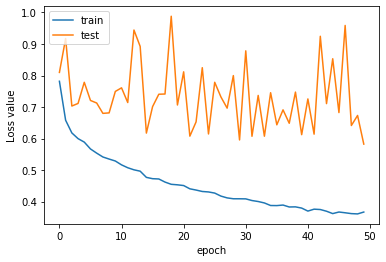

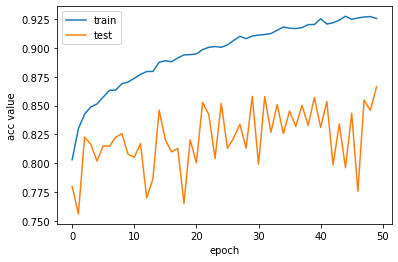

In [32]:
plot_history(history)

In [33]:
loss, acc = model.evaluate(X_test, Y_test)
print('test data loss:%.2f acc:%.4f' % (loss, acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.6179 - accuracy: 0.8587
test data loss:0.62 acc:0.8587
